<a href="https://colab.research.google.com/github/EliseuODaniel/Analise_temperatura_motor_eletrico/blob/main/Analise_1_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelagem da variação da temperatura de um PSMS

## Introdução

Os motores síncronos a ímãs permanentes (Permanent Magnet Synchronous Motor - PMSM) alimentados por inversor de freqüência podem são uma opção apropriada em várias aplicações na indústria devido ao seu alto torque e alto desempenho.
Os PMSMs possuem tamanho e volume reduzidos e podem funcionar em uma ampla faixa de velocidades.


![](https://alliedmarketresearch.files.wordpress.com/2017/02/permanent-magnet-synchronous-motor-pmsm.png?w=705)

Porém, alguns componentes sensíveis à temperatura são vulneráveis à falha sob estresse termal e precisam ser monitorados.

Um superaquecimento no estator pode fazê-lo derreter e, caso atinja os imãs permanentes, pode faze-los desmagnetizarem irreversivelmente.


![](https://images.squarespace-cdn.com/content/v1/56c20776f699bbc849dc0a69/1458920344064-XRVKU3O788XYJNS0TQ3A/ke17ZwdGBToddI8pDm48kH6fpDepVnHDbJBHVrcFH3VZw-zPPgdn4jUwVcJE1ZvWQUxwkmyExglNqGp0IvTJZamWLI2zvYWH8K3-s_4yszcp2ryTI0HqTOaaUohrI8PICKwaTIMLhQJ9fACjqaf26fF01mQeTIdmmTPu11VCbBkKMshLAGzx4R3EDFOm1kBS/image-asset.jpeg?format=500w)


Hoje em dia, os pontos quentes do estator são monitorados com sensores térmicos, que são embutidos e não podem ser substituídos. O problema é que perdem funcionalidade com o tempo.
Outro problema é que não é possível aplicar sensores térmicos no rotor devido à sua rotação e estrutura complexa. Caso fossem adicionados, aumentaria muito os custos de produção.

Então, o que se faz atualmente é adicionar uma margem de segurança em material no motor pra evitar o superaquecimento.
Como consequência, o potencial de sobrecarga de um PSMS nunca é totalmente utilizado. 
Este problema, junto com a pressão de custo constante no setor automotivo, conduz a investigação de métodos de estimativa de temperatura em tempo real suficientemente precisos.



## O teste

Foi utilizado um protótipo de motor PMSM de uma fabricante alemã com o nome não divulgado. As medições foram realizadas em laboratório numa bancada na Paderborn University.

![](https://scontent.fccm1-1.fna.fbcdn.net/v/t1.6435-9/203342690_4033096946759776_927109283836097485_n.jpg?_nc_cat=102&ccb=1-3&_nc_sid=730e14&_nc_ohc=gxuqQUs4cLsAX9AYRos&_nc_ht=scontent.fccm1-1.fna&oh=1bf31495419c43fa1fd2b080e4df5231&oe=60E0E991)

Para realização do teste, o motor foi excitado por ciclos de direção, denotando uma velocidade de motor de referência e um torque de referência. 

As correntes em coordenadas d-q e tensões nas coordenadas d-q são o resultado de uma estratégia de controle padrão tentando seguir a velocidade de referência e o torque. As colunas “motor_speed” e “torque” são as grandezas resultantes alcançadas por essa estratégia, derivadas das correntes e tensões definidas. A maioria dos ciclos de direção denotam caminhadas aleatórias no plano de velocidade-torque a fim de imitar os ciclos de direção do mundo real em um grau mais preciso do que as constantes subidas, acelerações e descidas. (Kirchgässner, W., Wallscheid, O. e Böcker, J., 2021)

## Variáveis mensuradas

Variáveis de entrada:
- u_d: Medição do componente d da voltagem em coordenadas-dq (em V);
- u_q: Medição do componente q da voltagem em coordenadas-dq (em V);
- i_d: Medição do componente d da corrente atual em coordenadas-dq;
- i_q: Medição do componente q da corrente atual em coordenadas-dq
- coolant: Temperatura do líquido de arrefecimento; 
- motor_speed: Velocidade do motor (em rpm);
- ambient: Temperatura ambiente (em ºC);

Variáveis de saída:
- pm: Temperatura do ímã permanente (em ºC) medida com termopares e transmitida de forma sem fio via uma unidade de termografia;
- stator_yoke: Temperatura da parte magnética do estator (em ºC) medida com termopares;
- stator_winding: Temperatura do enrolamento do estator (em ºC) medida com termopares;
- stator_tooth: Temperatura do dente do estator (em ºC) medida com termopares;

Variável não considerada:
- torque: Torque do motor (em Nm);


## Objetivo

Através dos dados obtidos das variáveis de entrada, encontrar meios de modelar o comportamento da temperatura do rotor.

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/notebooks/input/measures_v2.csv')
target_features = ['pm', 'stator_tooth', 'stator_yoke', 'stator_winding']
df.shape

# 1.333.816 linhas (medidas tomadas)
# 13 colunas (variáveis)

(1330816, 13)

In [4]:
df.info()

#todas as variávies já estão no formato numérico
#nenhum dado nulo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 132.0 MB


# EDA

In [5]:
df

# 5 primeiras e 5 últimas linhas

u_q    coolant  ...        torque  profile_id
0       -0.450682  18.805172  ...  1.871008e-01          17
1       -0.325737  18.818571  ...  2.454175e-01          17
2       -0.440864  18.828770  ...  1.766153e-01          17
3       -0.327026  18.835567  ...  2.383027e-01          17
4       -0.471150  18.857033  ...  2.081967e-01          17
...           ...        ...  ...           ...         ...
1330811 -2.152128  30.721298  ... -8.116730e-60          71
1330812 -2.258684  30.721306  ... -5.815891e-60          71
1330813 -2.130312  30.721312  ... -4.167268e-60          71
1330814 -2.268498  30.721316  ... -2.985978e-60          71
1330815 -2.100158  30.721319  ... -2.139547e-60          71

[1330816 rows x 13 columns]

- Features like torque, motor speed, rotor temperature (pm), stator yoke, winding and tooth temperature (resp. stator_yoke, stator_winding, stator_tooth), coolwater temperature (coolant) are all reasonably self-explanatory. The active and reactive current and voltage (resp. i_d, i_q, u_d, u_q) of the PMSM however, require some background knowledge of how a synchronous motor works. 

- The ambient temperature is measured by a thermal sensor located closely to the stator (as stated in the explanatory notes of the dataset). We can therefore assume that this will have an impact on the selfcooling capacity of the motor. A higher ambient temperature will probably result in a higher temperature for both the motor's stator and rotor.

In [6]:
#unidades das variáveis descritas na primeira célula

df.describe().T

count         mean  ...          75%          max
u_q             1330816.0    54.279005  ...    90.034393   133.036994
coolant         1330816.0    36.229995  ...    49.857487   101.598512
stator_winding  1330816.0    66.342745  ...    88.141137   141.362885
u_d             1330816.0   -25.133809  ...     1.470271   131.469788
stator_tooth    1330816.0    56.878582  ...    75.586682   111.946423
motor_speed     1330816.0  2202.080728  ...  3760.639058  6000.015137
i_d             1330816.0   -68.716810  ...    -2.979688     0.051897
i_q             1330816.0    37.412782  ...   100.612150   301.707855
pm              1330816.0    58.506776  ...    72.008371   113.606628
stator_yoke     1330816.0    48.187965  ...    61.460828   101.147964
ambient         1330816.0    24.565256  ...    26.217019    30.714205
torque          1330816.0    31.106032  ...    91.597176   261.005707
profile_id      1330816.0    40.793062  ...    65.000000    81.000000

[13 rows x 8 columns]

In [7]:
#checagem se há valores nulos
df.isnull().values.any()

False

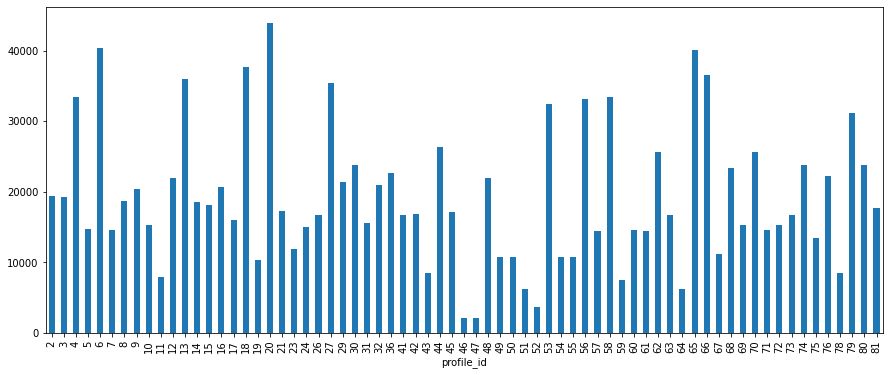

In [8]:
#tamanho de cada medição plotado para comparar
plt.figure(figsize=(15,6))
df.groupby('profile_id')['pm'].agg('count').plot(kind = 'bar')

In [11]:
# print the list of all testruns
profile_id_list = df.profile_id.unique()
print(profile_id_list)
print("amount of test runs: {0}".format(profile_id_list.size))

[17  5 12 32 21  2  4  7 19  3  9 23 27 26 11  6 10 13 31 18 30 29  8 24
 20 15 14 16 36 74 75 41 68 50 53 49 81 80 59 54 57 70 51 55 45 69 61 76
 56 64 72 73 62 65 63 43 47 66 42 48 67 44 79 52 60 46 58 78 71]
amount of test runs: 69


The various testruns (69 in total) are labelled by the profile_id (as mentioned in the dataset description). The indexes for these testruns however, are not incremental.

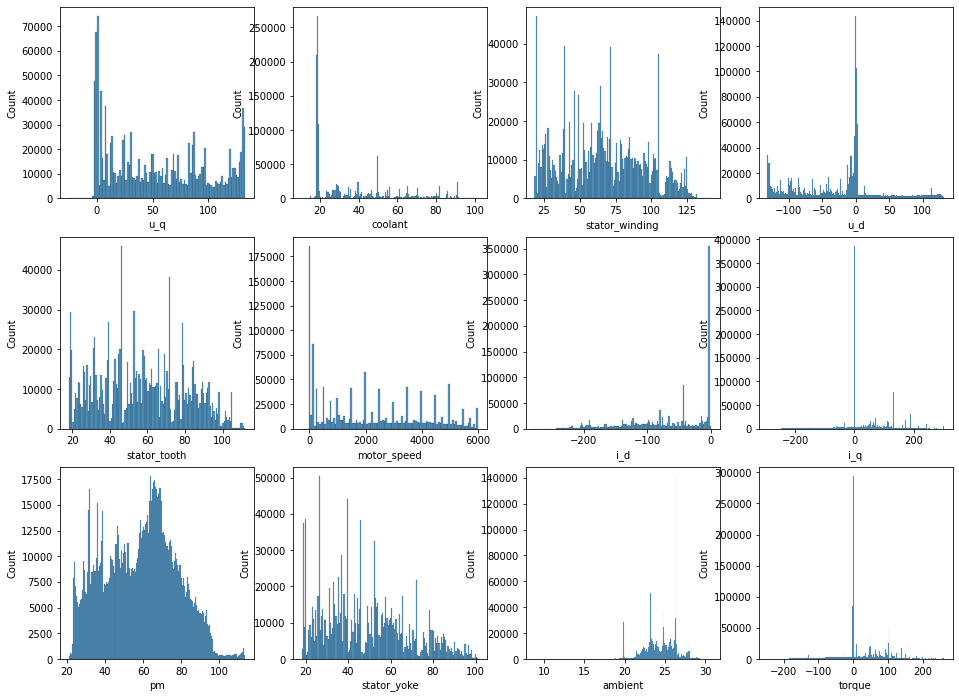

In [12]:
df_sem_id = df.drop(['profile_id'], axis=1) #tira a coluna id_profile
plt.figure(figsize=(16, 12))
for i in range(len(df_sem_id.columns)):
    plt.subplot(3, 4, i + 1)
    sns.histplot(data = df_sem_id[df_sem_id.columns[i]])
plt.show()

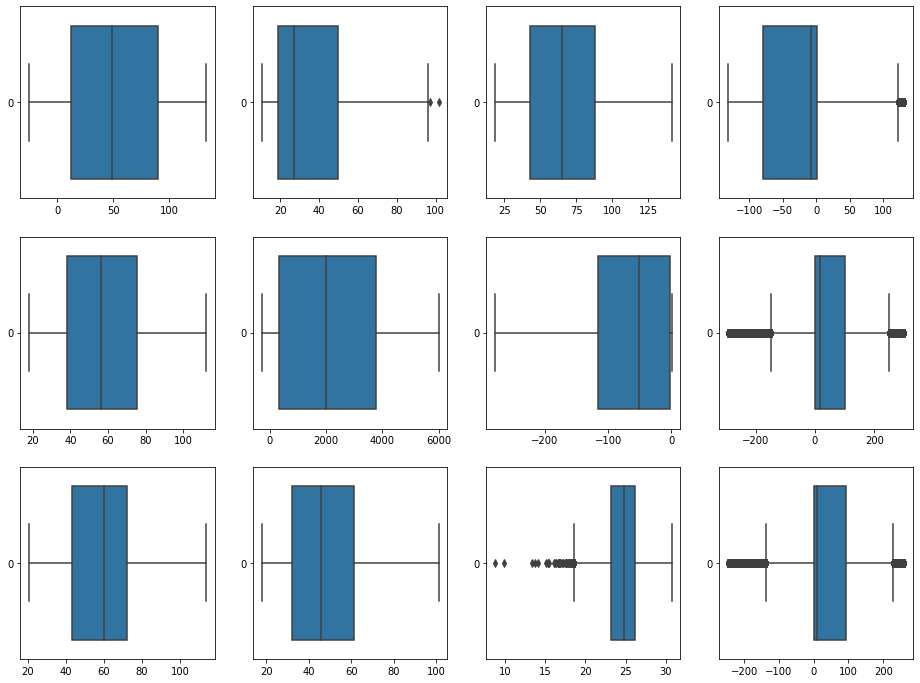

In [13]:
# boxplots e histogramas de todas as variáveis
plt.figure(figsize=(16, 12))
for i in range(len(df_sem_id.columns)):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(data = df_sem_id[df_sem_id.columns[i]], orient = "h")
plt.show()


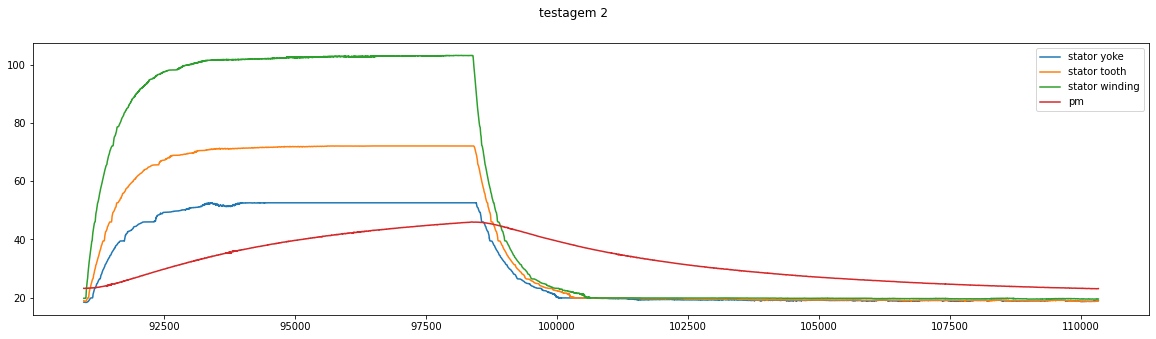

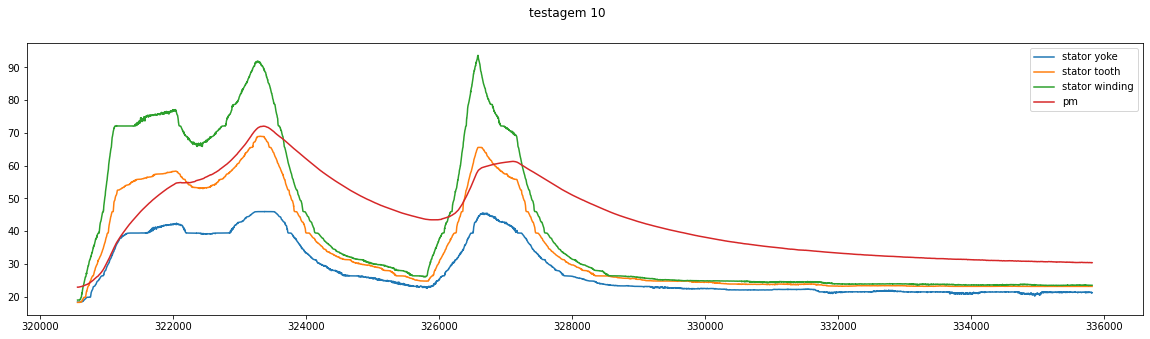

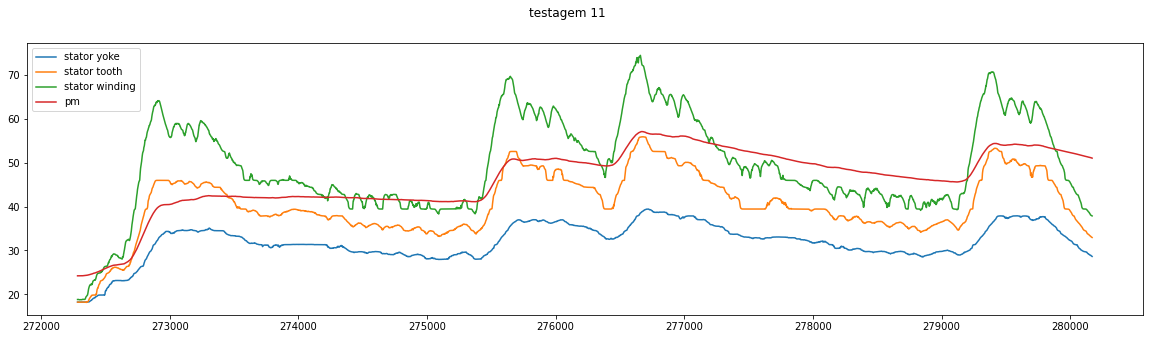

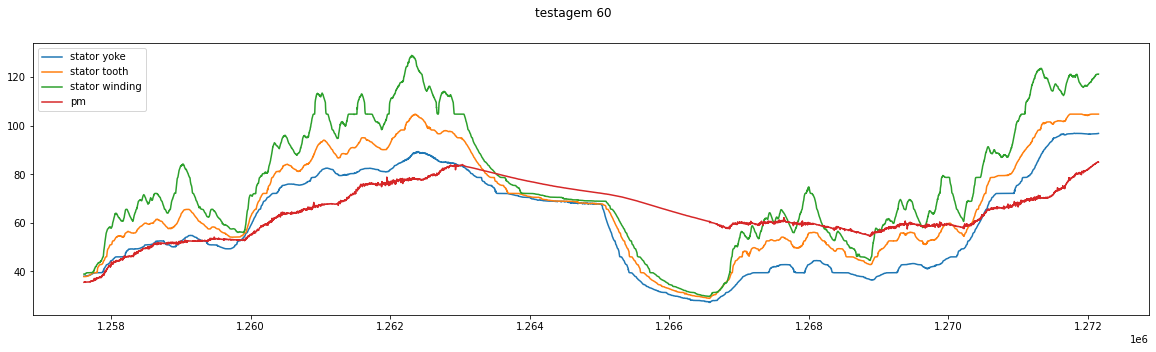

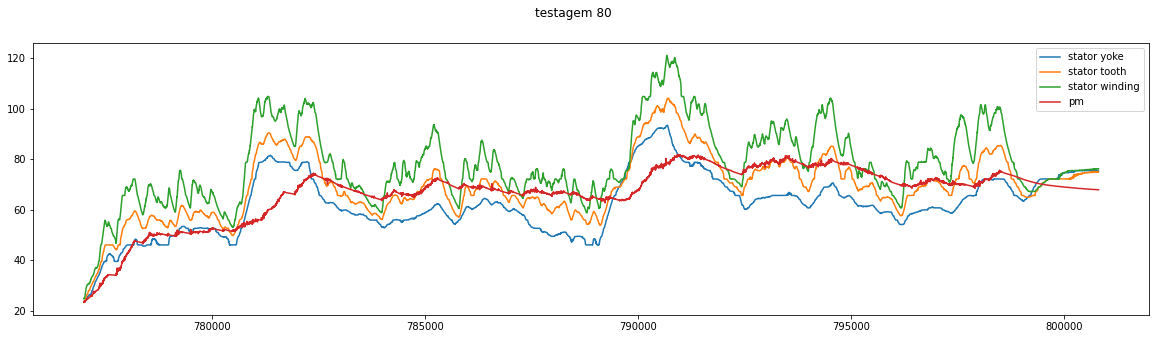

In [14]:
#plotagem dos valores das variáveis de saída de algumas realizações do teste
# como foram feitos 81 testagens, apenas uma amostra é apresentada visualmente

# visualmente se observa que a temperatura da parte magnética do estator (stator yoke), do dente do estator (stator tooth) e o enrolamento do estator (stator winding) se comportam de maneira proporcional, mas com intensidades diferentes
#já a variável da temperatura do rotor tem um comportamento diferente, com sua temperatura demorando mais a variar

testes_mostrados = [2, 10, 11, 60, 80]
for i in testes_mostrados:
    plt.figure(figsize=(20,5))
    df[df['profile_id'] == i]['stator_yoke'].plot(label = 'stator yoke')
    df[df['profile_id'] == i]['stator_tooth'].plot(label = 'stator tooth')
    df[df['profile_id'] == i]['stator_winding'].plot(label = 'stator winding')
    df[df['profile_id'] == i]['pm'].plot(label = 'pm')
    plt.suptitle(f'testagem {i}')    
    plt.legend()

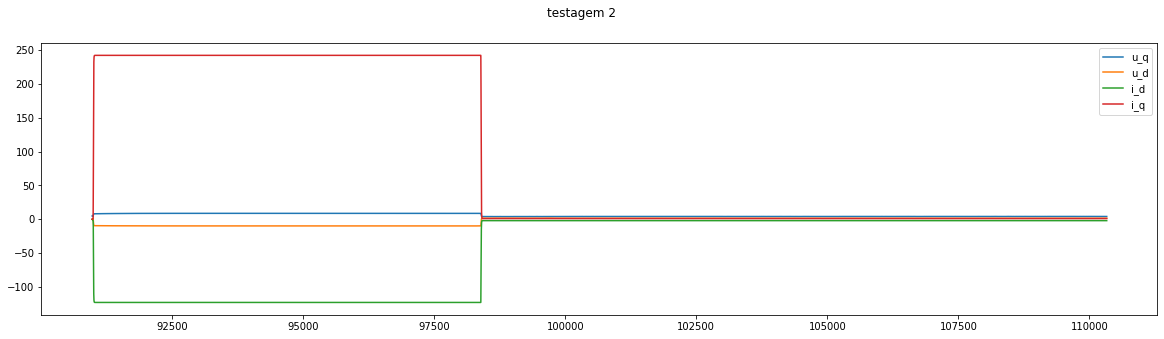

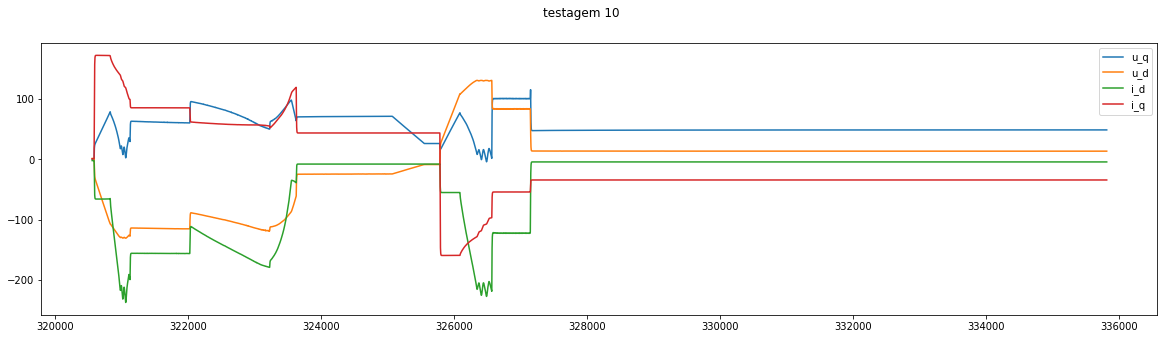

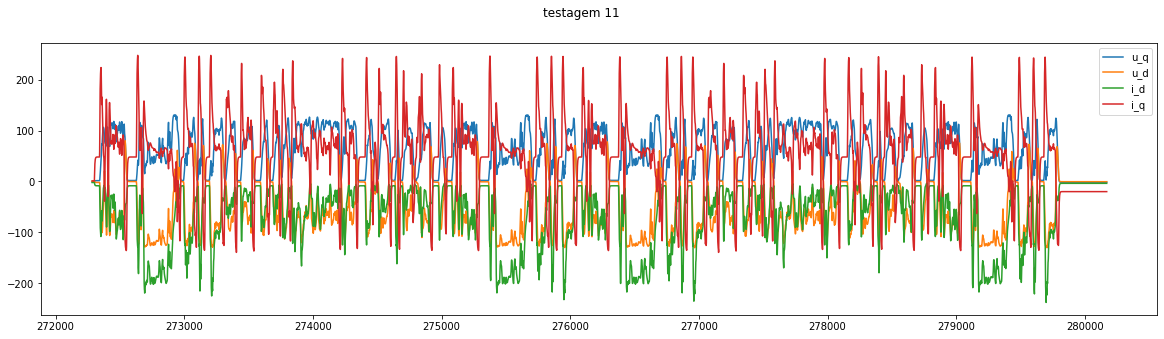

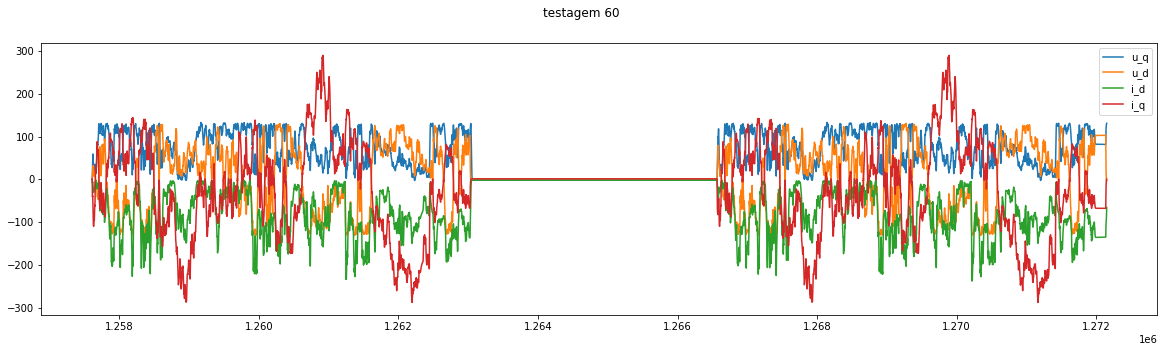

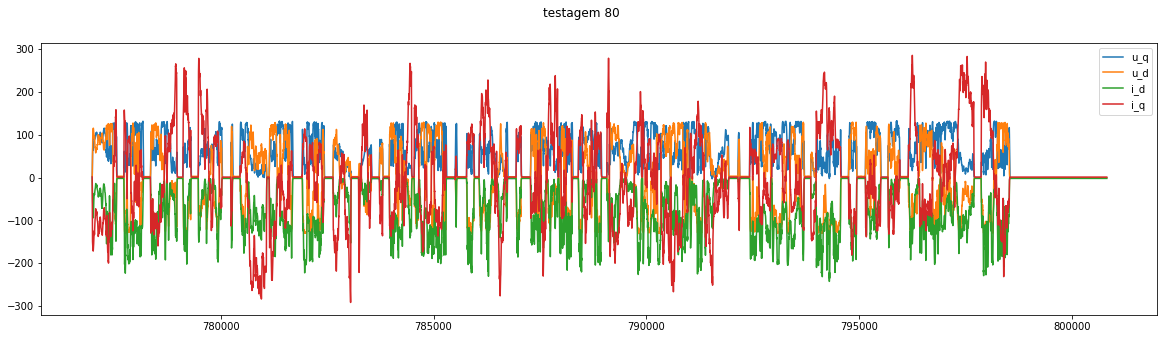

In [15]:
#plotagem dos valores das variáveis de entrada (voltagem, corrente) de algumas realizações do teste
for i in testes_mostrados:
    plt.figure(figsize=(20,5))
    df[df['profile_id'] == i]['u_q'].plot(label = 'u_q')

    df[df['profile_id'] == i]['u_d'].plot(label = 'u_d')
    df[df['profile_id'] == i]['i_d'].plot(label = 'i_d')
    df[df['profile_id'] == i]['i_q'].plot(label = 'i_q')


    plt.suptitle(f'testagem {i}')    
    plt.legend()

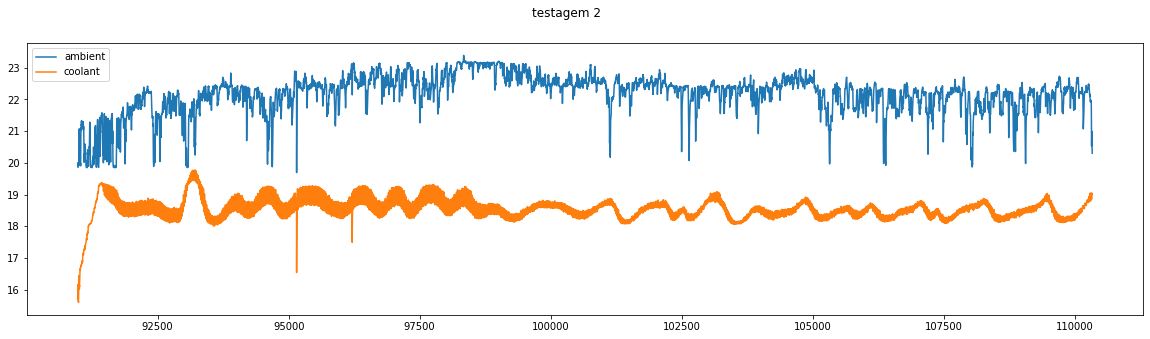

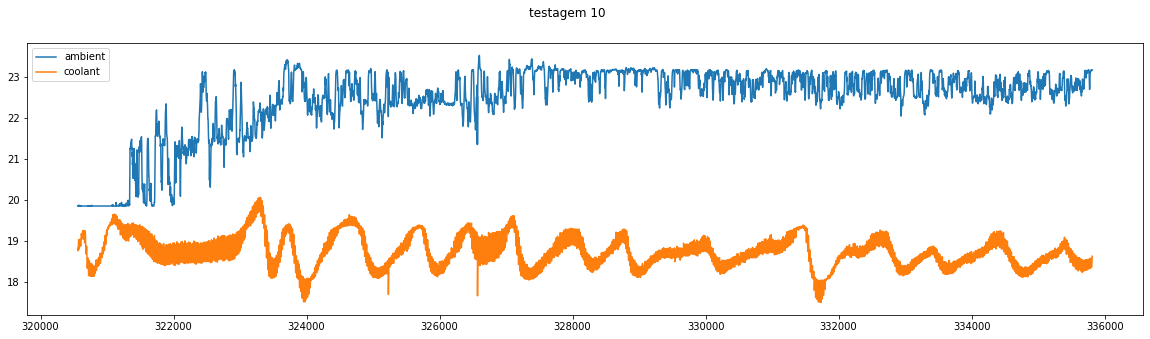

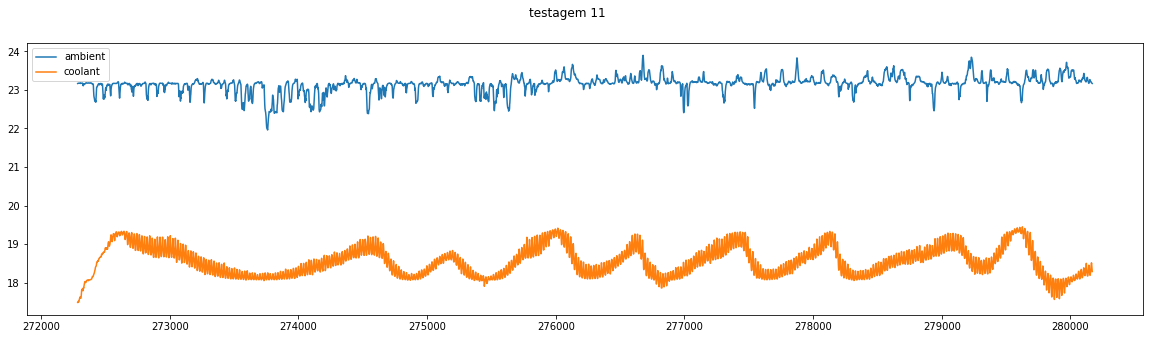

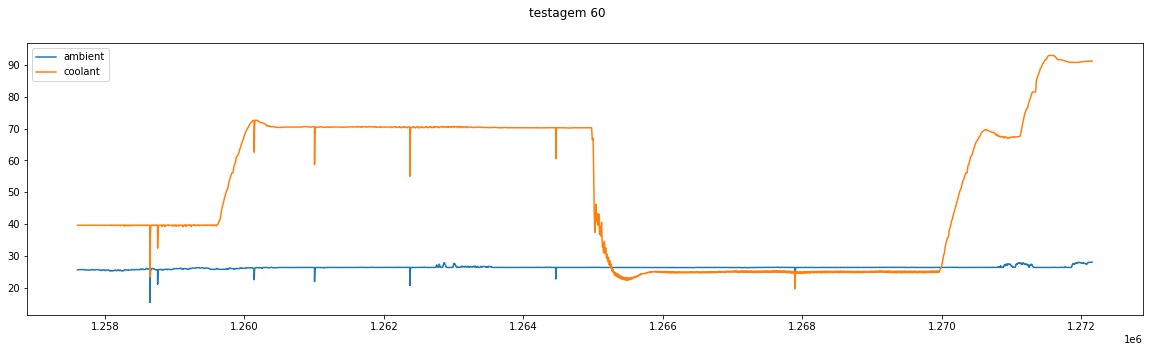

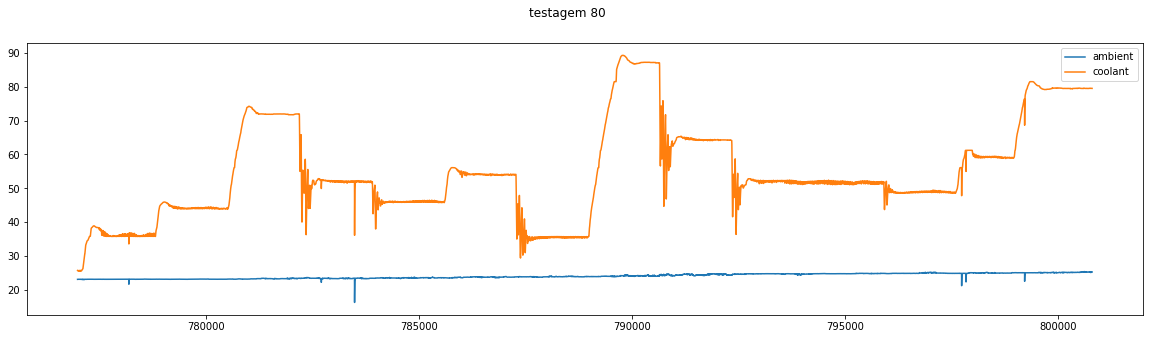

In [16]:
#variáveis de entrada da temperatura do liquido de arrefecimento e temperatura ambiente
for i in testes_mostrados:
    plt.figure(figsize=(20,5))
    df[df['profile_id'] == i]['ambient'].plot(label = 'ambient')
    df[df['profile_id'] == i]['coolant'].plot(label = 'coolant')
    plt.suptitle(f'testagem {i}')    
    plt.legend()

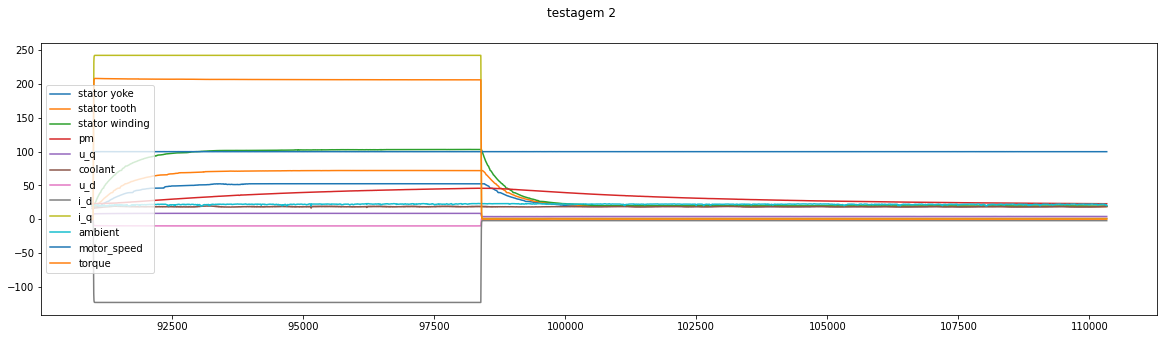

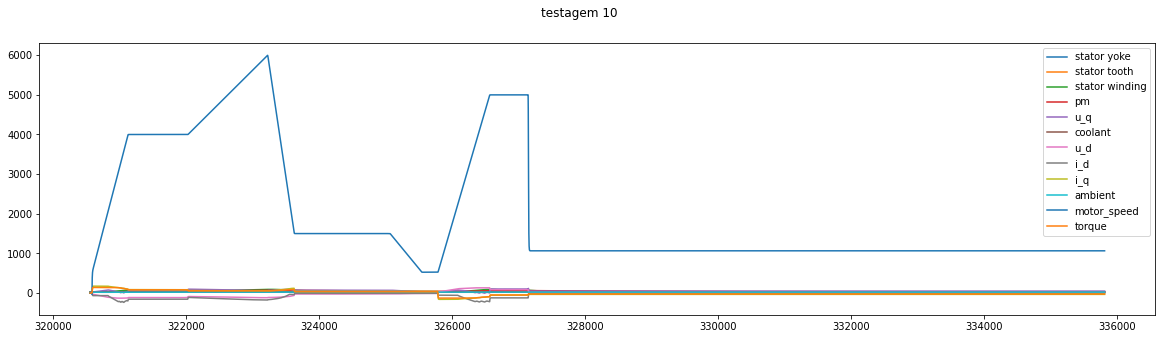

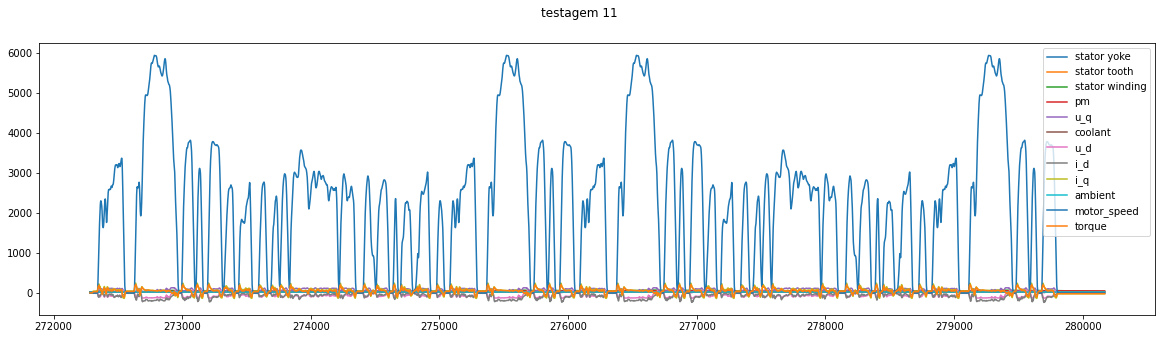

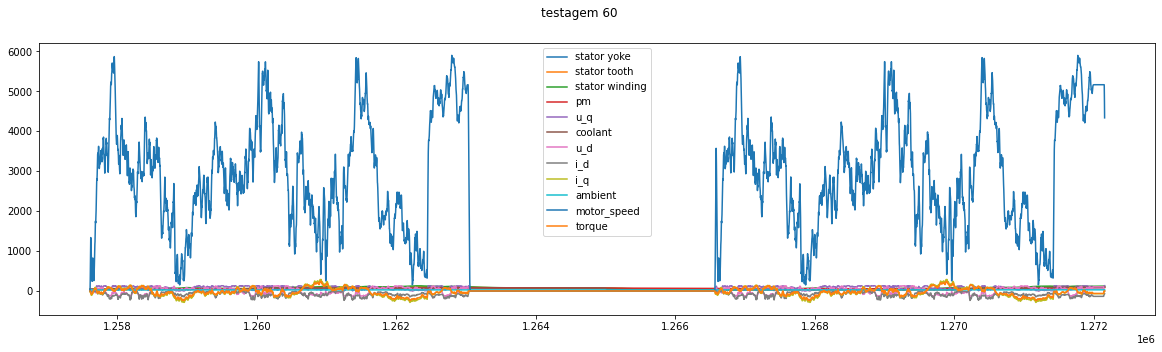

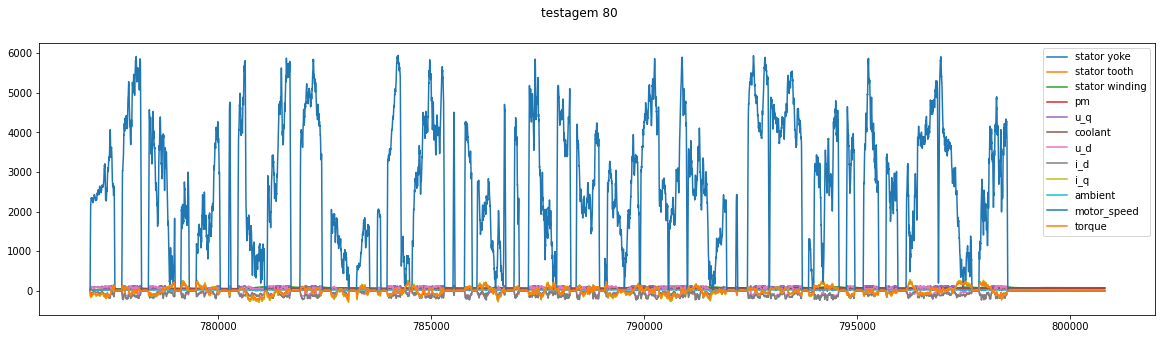

In [17]:
#variáveis de entrada e saídas juntas em algumas realizações do teste


# nos tres testes mostrados, é possível observar que assim que o motor é acionado e permanece constante, a temperatura começa a aumentar até alcançar uma certa estabilidade
#por outro lado, quando o motor é acionado e parado seguidas vezes, a temperatura alcança valores mais elevados
for i in testes_mostrados:
    plt.figure(figsize=(20,5))
    df[df['profile_id'] == i]['stator_yoke'].plot(label = 'stator yoke')
    df[df['profile_id'] == i]['stator_tooth'].plot(label = 'stator tooth')
    df[df['profile_id'] == i]['stator_winding'].plot(label = 'stator winding')
    df[df['profile_id'] == i]['pm'].plot(label = 'pm')
    df[df['profile_id'] == i]['u_q'].plot(label = 'u_q')
    df[df['profile_id'] == i]['coolant'].plot(label = 'coolant')
    df[df['profile_id'] == i]['u_d'].plot(label = 'u_d')
    df[df['profile_id'] == i]['i_d'].plot(label = 'i_d')
    df[df['profile_id'] == i]['i_q'].plot(label = 'i_q')
    df[df['profile_id'] == i]['ambient'].plot(label = 'ambient')
    df[df['profile_id'] == i]['motor_speed'].plot(label = 'motor_speed')
    df[df['profile_id'] == i]['torque'].plot(label = 'torque')
    plt.suptitle(f'testagem {i}')    
    plt.legend()

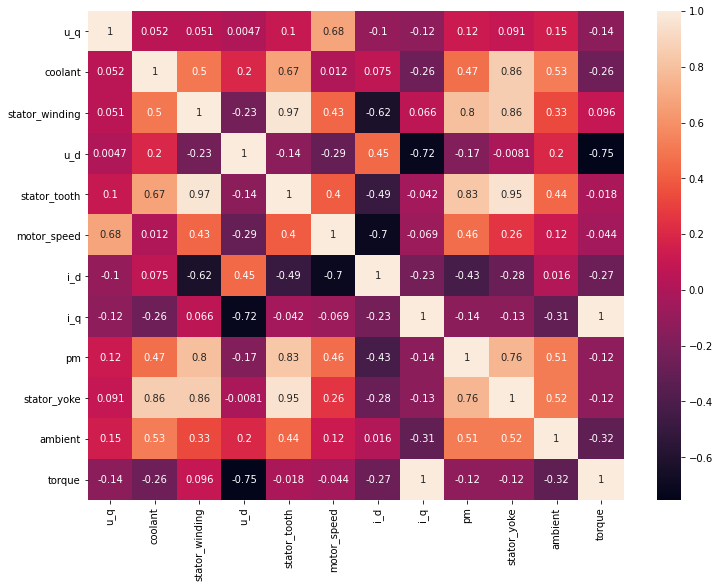

In [18]:
# matriz de correlações de pearson
fig = plt.figure(figsize=(12,9))
sns.heatmap(df_sem_id.corr(),annot=True)
plt.show()

The correlation matrix shows that there is a significant correlation between the three different stator temperatures.

<Figure size 360x360 with 0 Axes>

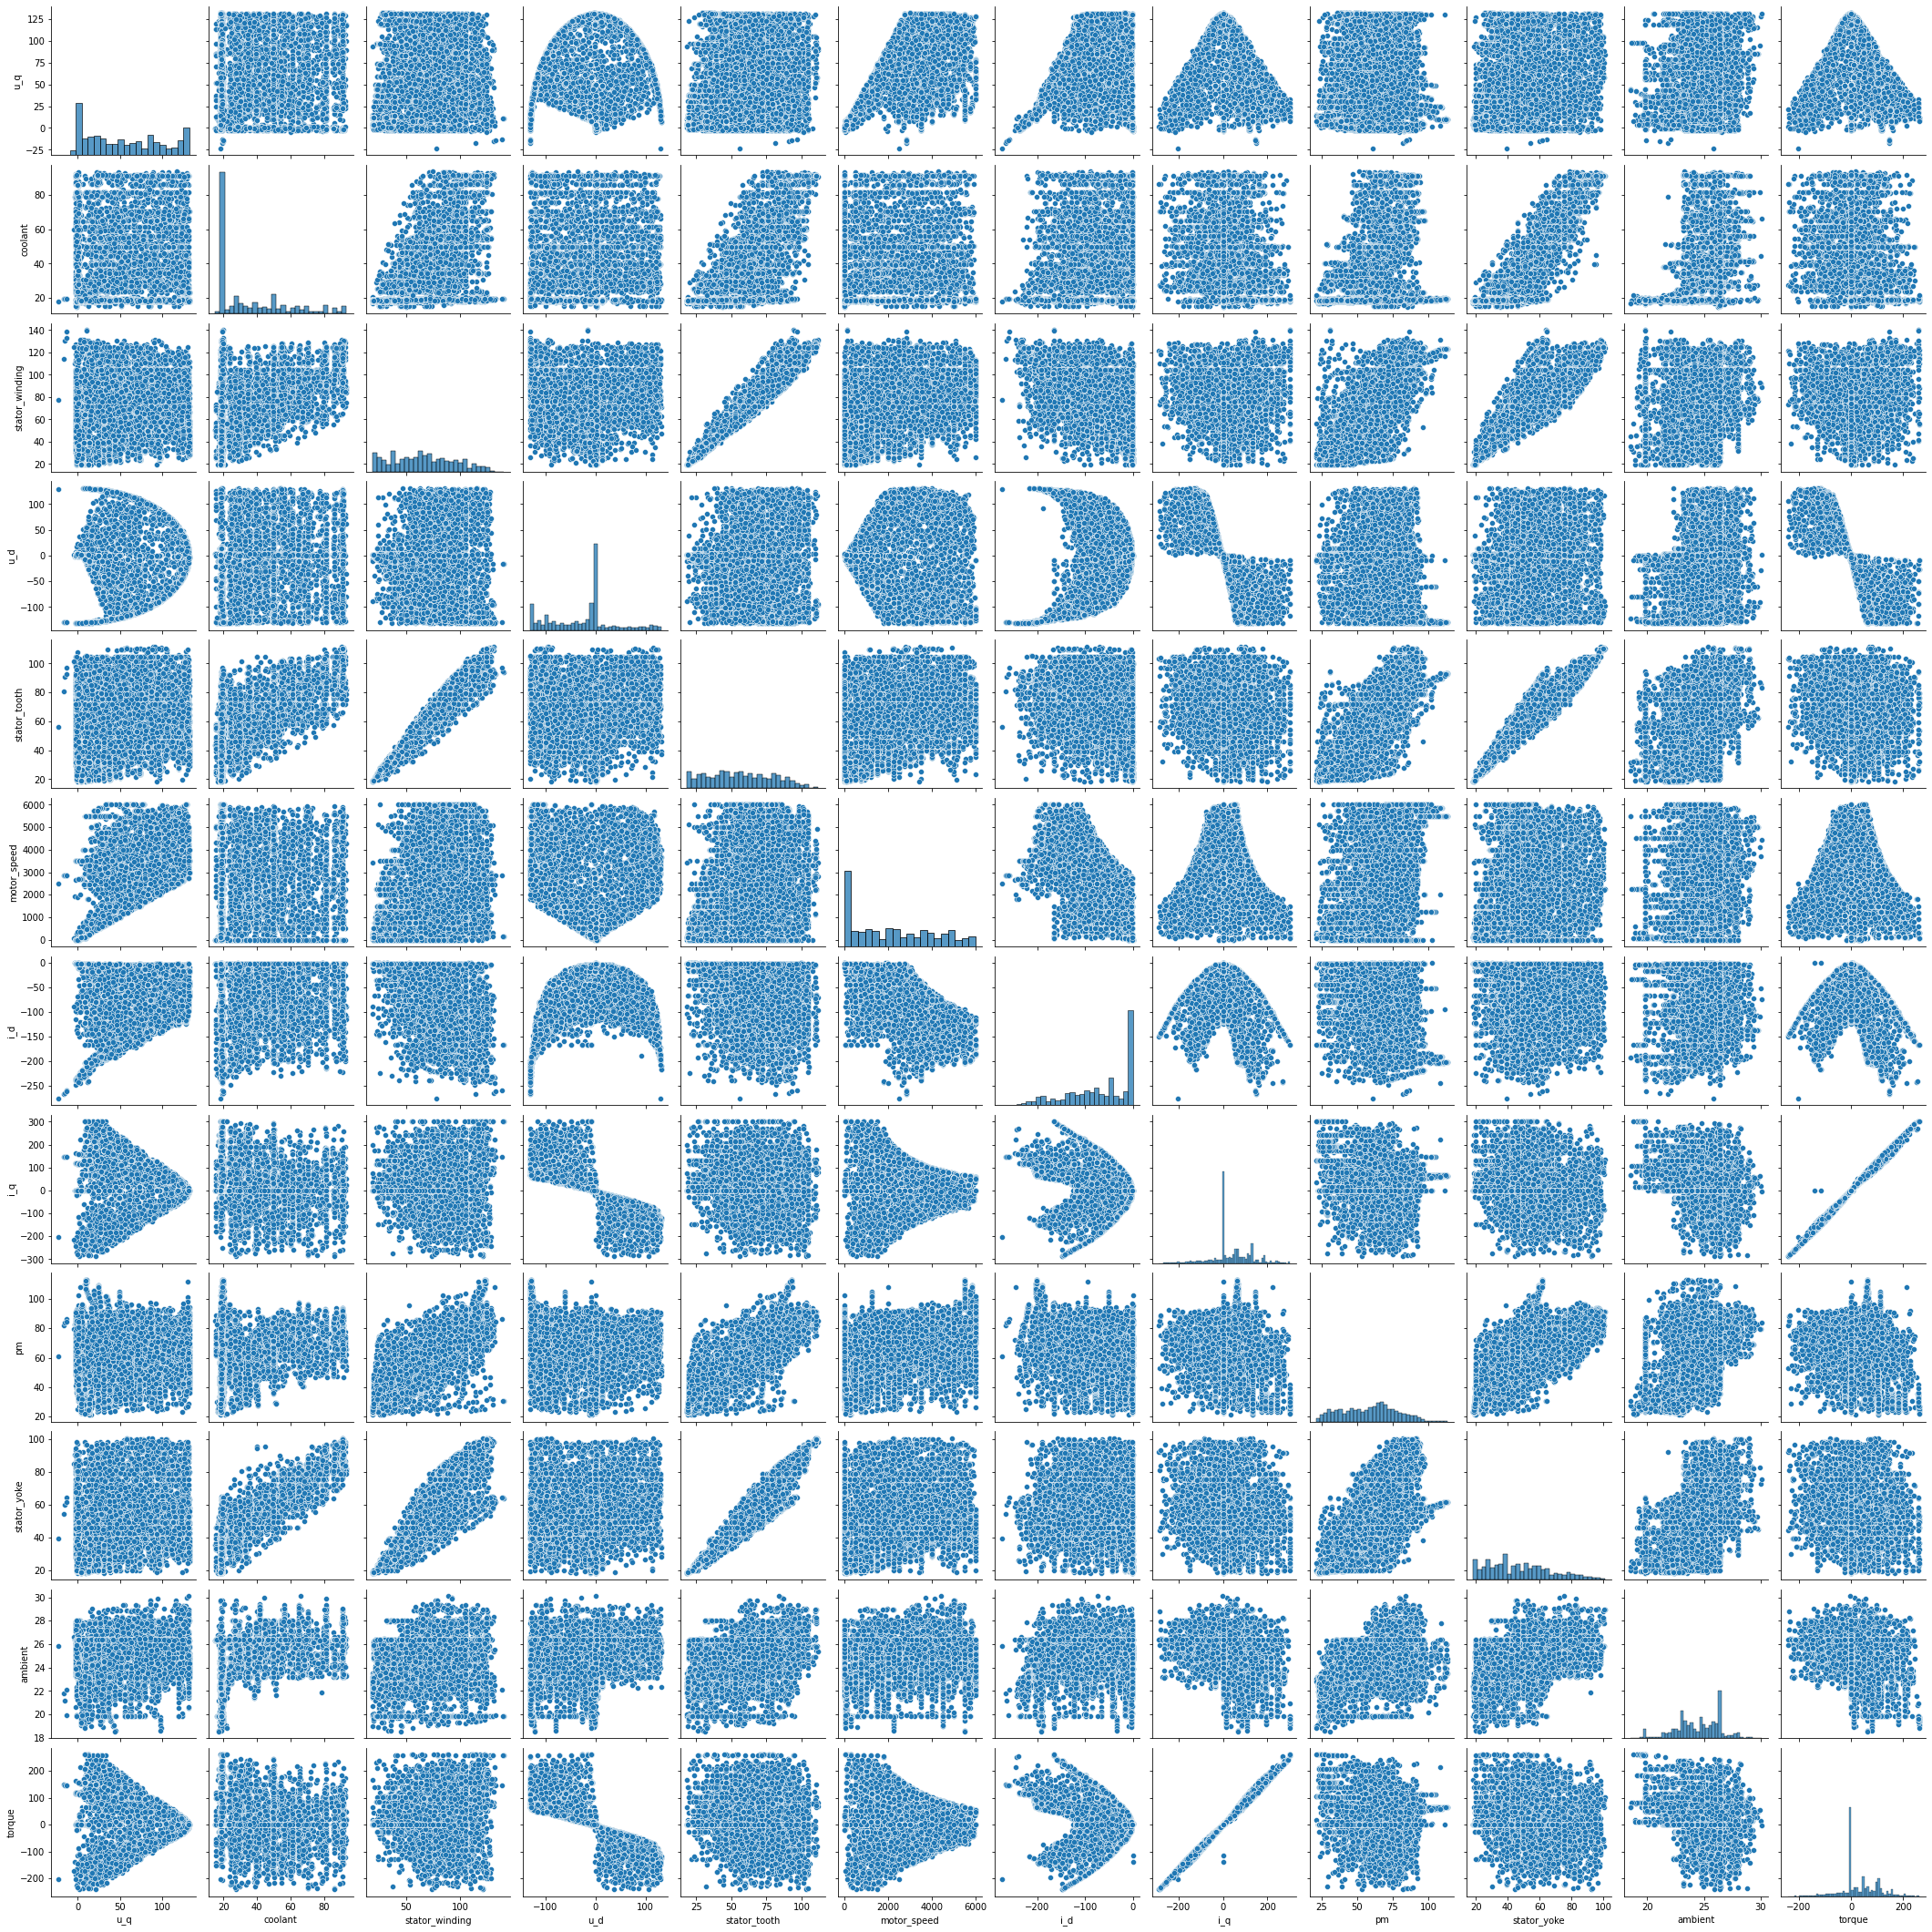

In [19]:
#plotagem de todas as dispersões entre as variáveis
#sorteando apenas 10000 valores 
plt.figure(figsize=(5, 5))
sns.pairplot(df_sem_id.sample(10000))
plt.show()